# League predictability

- In this part we will try to analize which league is most competitive and most predictable and which are the least.
- And how we can predict the match outcome - if team will win.

In [143]:
%matplotlib inline

import sqlite3
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import os
import itertools
from datetime import datetime

from scipy.stats import entropy


import statsmodels.api as sm
import math
from dateutil.relativedelta import relativedelta
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

from generic_functions import end_of_year_player, end_of_year_team, team_to_player_home, team_to_player_away, team_to_player, top_N_team, league_to_team, top_leagues, box_plot_leagues

## League predictability analysis

To analize which league is more predictabe to win home team, draw, win away team, we will use betting scores (B365) and the information entropy concept.

<i>"In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes."</i>

In our case, the event is a football match and there are three possible outcomes: 
- a win for the first team, 
- a win for the other team 
- or a draw. 

If the three outcomes are equally probable, the uncertainty is maximal and so is the entropy (log(3)=1.584963). As the probability of a particular outcome will get closer to one - almost no uncertainty - the match entropy will approach zero.

Finally, in order to derive the probability for each team to win in a particular game during the season, we used the odds given for each match by a gambling agency. We reckon these reflect the objective chance for each team to win a match in a particular point in time. From these probabilities we calculated the entropy score for each league and each team in different seasons.

In [6]:
#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Input//database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [7]:
# Merge countries with leagues
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [8]:
# Selecting fields
matches = matches[matches.league_id.isin(leagues.id)]

matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

matches.dropna(inplace=True)

matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1.73,3.40,5.00
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,1.95,3.20,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,2.38,3.30,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,1.44,3.75,7.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,5.00,3.50,1.65


In [13]:
def match_entropy(row):

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #change odds to probability

    probs = [1/o for o in odds]

    #normalize to sum to 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)


#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)

In [19]:
#compute mean entropy for every league in every season

entropy_means = matches.groupby(['season','league_id']).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]

entropy_means.head(10)

,Belgium,England,France,Germany,Italy,Netherlands,Portugal,Scotland,Spain
season,,,,,,,,,
2008/2009,0.994534,0.984556,1.026638,1.004276,1.002201,0.976775,1.004260,0.989919,1.010859
2009/2010,1.002933,0.956496,1.013821,0.997925,1.006755,0.953904,0.983286,0.991430,0.977810
2010/2011,1.001498,0.983258,1.026236,1.016264,1.006029,0.948478,0.989018,0.981203,0.975032
2011/2012,0.993622,0.969593,1.024915,1.001298,1.003077,0.927274,0.970013,0.992080,0.955339
2012/2013,1.000187,0.981472,1.016116,0.993993,1.003565,0.950659,0.975749,1.020779,0.970580
2013/2014,NaN,0.960473,1.004439,0.977500,0.992622,0.964687,0.968953,1.006370,0.944218
2014/2015,0.999532,0.980301,1.012495,0.985835,0.999100,0.969785,0.960539,0.993735,0.933637
2015/2016,1.000230,0.997819,1.013928,0.974657,0.985284,0.981676,0.960114,0.999148,0.946813


Text(7.6, 0.94, 'more predictable')

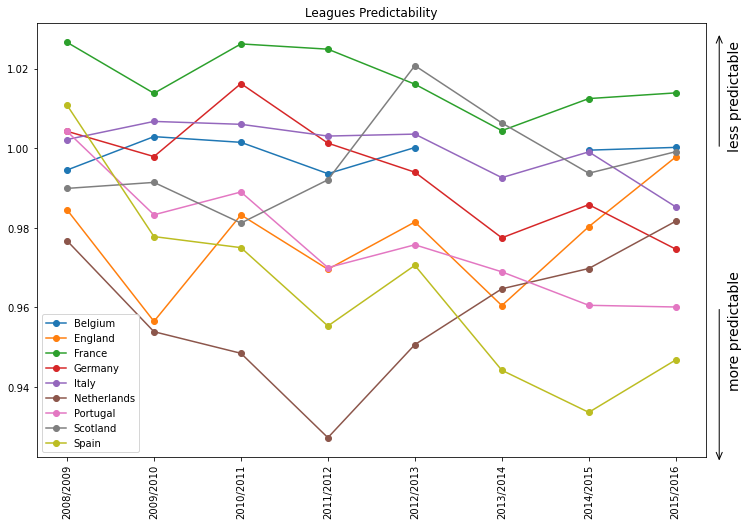

In [39]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=12)

#set ticks roatation
plt.xticks(rotation=90)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.5, 1),xy=(7.5, 1.029),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.5, 0.96),xy=(7.5, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.6, 1.0), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.6, 0.94), annotation_clip=False,fontsize=14,rotation='vertical')

- We can see that he Spanish league has been the least competitive league out of the all leagues in the dataset.
- Contraro to, the French league is the most competitive one. 
- The English league has changed its position in time, raising its rank to the 2nd most competitive league in 2015/2016. 
- Italy over the years remained quite stable and in second most competitice league position. 
- Germany and Portugal was quite decreasing over the years.

## Home team match won prediction

Based on matches results and teams performance attributes over the years we will try to find the model which best predicts match outcome (e.g. if home team won).

- First we will try teams attributes as model features.
- Later we will add teams players ratings score to check if it improves the model and prediction results.

### Based on teams performance attributes

First we prepare match dataset and selest most relevant columns for further analysis

In [131]:
df_m = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/matches.csv")
df_m.info()
df_m['year'] = df_m.date.apply(lambda x: pd.to_datetime(x).year)
df_m['HTeamWon'] = np.where(df_m.home_team_goal > df_m.away_team_goal, 1,0)
df_m['ATeamWon'] = np.where(df_m.home_team_goal < df_m.away_team_goal, 1,0)
df_m = df_m.sort_values(by=['home_team_api_id', 'year','season','date'], ascending=True)
df_m['PreviousHWonMatchCum'] = df_m.groupby(['home_team_api_id', 'year','season'])['HTeamWon'].cumsum()
df_m = df_m.sort_values(by=['away_team_api_id', 'year','season','date'], ascending=True)
df_m['PreviousAWonMatchCum'] = df_m.groupby(['away_team_api_id', 'year','season'])['ATeamWon'].cumsum()
df_m = df_m[['year','date','country_id','league_id_x','season','stage','match_api_id',
      'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal',
        'HTeamWon','ATeamWon', 'PreviousHWonMatchCum','PreviousAWonMatchCum']]

df_m.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 121 entries, id_x to away_team_short_name
dtypes: float64(96), int64(9), object(16)
memory usage: 24.0+ MB


,year,date,country_id,league_id_x,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,HTeamWon,ATeamWon,PreviousHWonMatchCum,PreviousAWonMatchCum
15722,2008,2008-08-10,15722,15722,2008/2009,1,506542,8020,1601,0,0,0,0,0,0
15915,2008,2008-08-30,15722,15722,2008/2009,4,506567,8242,1601,3,0,1,0,2,0


We prepare the team dataset for the joining with match dataset.
We count avg team attributes per year and team, then selecting the last attributes values over the years.

In [132]:
df_t = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/teams.csv")
df_t = df_t[['team_api_id','date','buildUpPlaySpeed', 'buildUpPlayDribbling', 
      'buildUpPlayPassing','chanceCreationPassing', 
      'chanceCreationCrossing', 'chanceCreationShooting', 
      'defencePressure', 
      'defenceAggression', 'defenceTeamWidth']]
df_t['year'] = df_t.date.apply(lambda x: pd.to_datetime(x).year)
df_t['rn'] = df_t.groupby(['team_api_id','year'])["date"].rank(method="first", ascending=False)
df_ty = (df_t.groupby(['year','team_api_id'])
                 .agg(AVGbuildUpPlaySpeed=('buildUpPlaySpeed','mean'),
                      AVGbuildUpPlayDribbling=('buildUpPlayDribbling','mean'),
                      AVGbuildUpPlayPassing=('buildUpPlayPassing','mean'),
                      AVGchanceCreationPassing=('chanceCreationPassing','mean'),
                      AVGchanceCreationShooting=('chanceCreationShooting','mean'),
                      AVGdefencePressure=('defencePressure','mean'),
                      AVGdefenceAggression=('defenceAggression','mean'),
                      AVGdefenceTeamWidth=('defenceTeamWidth','mean')
                    )
        )
df_tt = df_t[df_t.rn == 1].reset_index()
df_tt = df_tt.drop(columns=['index'])
    
dft = pd.merge(df_tt,df_ty, how='left',on=['year','team_api_id'])
print(dft.shape)
dft = dft.dropna()
print(dft.shape)
dft.head(2)

(1457, 21)
(488, 21)


,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,...,year,rn,AVGbuildUpPlaySpeed,AVGbuildUpPlayDribbling,AVGbuildUpPlayPassing,AVGchanceCreationPassing,AVGchanceCreationShooting,AVGdefencePressure,AVGdefenceAggression,AVGdefenceTeamWidth
1,9930,2014-09-19 00:00:00,52,48.0,56,54,63,64,47,44,...,2014,1.0,52.0,48.0,56.0,54.0,64.0,47.0,44.0,54.0
2,9930,2015-09-10 00:00:00,47,41.0,54,54,63,64,47,44,...,2015,1.0,47.0,41.0,54.0,54.0,64.0,47.0,44.0,54.0


We join home and away teams attributes with match data

In [133]:
dfm = pd.merge(df_m,dft,
               how='left',
               left_on=['year','home_team_api_id'],
               right_on=['year','team_api_id'],
               suffixes=('', '_home'))
dfm = pd.merge(dfm,dft,
               how='left',
               left_on=['year','away_team_api_id'],
               right_on=['year','team_api_id'],
               suffixes=('', '_away'))
print(dfm.shape)
dfm = dfm.dropna()
print(dfm.shape)
dfm.head(3)

(25979, 55)
(6077, 55)


,year,date,country_id,league_id_x,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,defenceTeamWidth_away,rn_away,AVGbuildUpPlaySpeed_away,AVGbuildUpPlayDribbling_away,AVGbuildUpPlayPassing_away,AVGchanceCreationPassing_away,AVGchanceCreationShooting_away,AVGdefencePressure_away,AVGdefenceAggression_away,AVGdefenceTeamWidth_away
86,2014,2014-02-23,15722,15722,2013/2014,23,1467723,8025,1601,2,...,49.0,1.0,53.0,48.0,38.0,66.0,50.0,43.0,44.0,49.0
87,2014,2014-03-08,15722,15722,2013/2014,25,1467745,10265,1601,0,...,49.0,1.0,53.0,48.0,38.0,66.0,50.0,43.0,44.0,49.0
88,2014,2014-03-23,15722,15722,2013/2014,27,1467854,8023,1601,3,...,49.0,1.0,53.0,48.0,38.0,66.0,50.0,43.0,44.0,49.0


We check matches distribution per Home team won matches:

In [134]:
won_matches = dfm.groupby('HTeamWon').agg(Occur=('match_api_id','count')).reset_index()
won_matches['Percent'] = round(won_matches.Occur/ won_matches.Occur.sum()*100,1)
won_matches

,HTeamWon,Occur,Percent
0,0,3333,54.8
1,1,2744,45.2


We define the prediction labels and model features. Then we split dataset to train and test samples

In [135]:
y = dfm['HTeamWon']

#define explanatory variable
x = dfm[['stage','AVGbuildUpPlaySpeed', 'AVGbuildUpPlayDribbling', 
         'AVGbuildUpPlayPassing', 'AVGchanceCreationPassing', 'AVGchanceCreationShooting', 
         'AVGdefencePressure', 'AVGdefenceAggression', 'AVGdefenceTeamWidth',
         'AVGbuildUpPlaySpeed_away', 'AVGbuildUpPlayDribbling_away', 'AVGbuildUpPlayPassing_away', 
         'AVGchanceCreationPassing_away', 'AVGchanceCreationShooting_away', 'AVGdefencePressure_away', 
         'AVGdefenceAggression_away', 'AVGdefenceTeamWidth_away',
         'PreviousHWonMatchCum','PreviousAWonMatchCum'
        ]]

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)

In [136]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4861, 19)
(4861,)
(1216, 19)
(1216,)


Chekcing train and test samples distribution per matches home team won

In [137]:
won_matches_train = (y_train.reset_index().groupby('HTeamWon')
                             .agg(Occur=('index','count')).reset_index())
won_matches_train['Percent'] = round(won_matches_train.Occur/ won_matches_train.Occur.sum()*100,1)
won_matches_train

,HTeamWon,Occur,Percent
0,0,2651,54.5
1,1,2210,45.5


In [138]:
won_matches_test = (y_test.reset_index().groupby('HTeamWon')
                             .agg(Occur=('index','count')).reset_index())
won_matches_test['Percent'] = round(won_matches_test.Occur/ won_matches_test.Occur.sum()*100,1)
won_matches_test

,HTeamWon,Occur,Percent
0,0,682,56.1
1,1,534,43.9


We are applying Logistic regresion for the fitting model and prediction

In [139]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

Sonfusion matrix and accuracy score

In [140]:
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print(lr_conf_matrix)
print('Accuracy:',lr_acc_score*100)

[[537 145]
 [155 379]]
Accuracy: 75.32894736842105


Other model quality metrics:

In [142]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Precision:',precision_score(y_test, lr_predict, average='macro')*100)
print('Recall:',recall_score(y_test, lr_predict, average='macro')*100)
print('F1:',f1_score(y_test, lr_predict, average='macro')*100)

Precision: 74.96470017208667
Recall: 74.85639285204344
F1: 74.90527567049968


The model with teams performance attributes features is moderate quality. 
(ACC = 75.3%, F1 = 74.9%) This means, that model 75.3% of times predicts that home team would win.

### Adding players ratings per teams attributes

Lets add players overall ratings per teams as features

In [144]:
df_p = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/players.csv")
df_p.head(2)

df_t = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/teams.csv")
df_t.head(2)

df_m = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/matches.csv")
df_m = df_m.rename(columns={'league_id_x':'league_id'})
df_m.head(2)

df_l = pd.read_sql_query("""
            SELECT 
                *
            FROM League AS L 
            """, con)

df_l.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


In [162]:
seasons_df = list(dfm.season.unique())
seasons_df

['2013/2014', '2014/2015', '2015/2016']

In [163]:
COLUMN_NAMES = ['season','rank1','team_api_id','overall_rating','team_long_name']
df_ratings = pd.DataFrame(columns=COLUMN_NAMES)
df_ratings

,season,rank1,team_api_id,overall_rating,team_long_name


In [164]:
for i in seasons_df:
    df = top_N_team(df_t,df_p,df_m,season=i,n=11000)
    df.index = range(1,len(df.index)+1)
    df.reset_index(level=0, inplace=True)
    df.rename( columns={"index":"rank1"},inplace=True)
    df_rank = df
    df['season'] = i
    df_ratings = df_ratings.append(df)
df_ratings

,season,rank1,team_api_id,overall_rating,team_long_name
0,2013/2014,1,8634,1277.0,FC Barcelona
1,2013/2014,2,9823,1270.0,FC Bayern Munich
2,2013/2014,3,8456,1259.0,Manchester City
3,2013/2014,4,8455,1250.0,Chelsea
4,2013/2014,5,8633,1234.0,Real Madrid CF
...,...,...,...,...,...
204,2015/2016,205,8429,924.0,Hamilton Academical FC
205,2015/2016,206,9824,912.0,FC Vaduz
206,2015/2016,207,9927,899.0,Motherwell
207,2015/2016,208,9930,878.0,FC Aarau


Match dataset joining with teams players ratings

In [172]:
dfmp = pd.merge(dfm,df_ratings,how='left',
                left_on=['season','home_team_api_id'],
                right_on=['season','team_api_id'],
                suffixes=('', '_home'))
dfmp = pd.merge(dfmp,df_ratings,how='left',
                left_on=['season','away_team_api_id'],
                right_on=['season','team_api_id'],
                suffixes=('', '_away'))
dfmp = dfmp.dropna()
print(dfmp.shape)
dfmp.head(3)

(6071, 63)


,year,date,country_id,league_id_x,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,AVGdefenceAggression_away,AVGdefenceTeamWidth_away,rank1,team_api_id_home,overall_rating,team_long_name,rank1_away,team_api_id_away,overall_rating_away,team_long_name_away
0,2014,2014-02-23,15722,15722,2013/2014,23,1467723,8025,1601,2,...,44.0,49.0,170,8025,1000.0,Śląsk Wrocław,190,1601,944.0,Ruch Chorzów
1,2014,2014-03-08,15722,15722,2013/2014,25,1467745,10265,1601,0,...,44.0,49.0,174,10265,996.0,Wisła Kraków,190,1601,944.0,Ruch Chorzów
2,2014,2014-03-23,15722,15722,2013/2014,27,1467854,8023,1601,3,...,44.0,49.0,169,8023,1001.0,Pogoń Szczecin,190,1601,944.0,Ruch Chorzów


In [173]:
won_matches = dfmp.groupby('HTeamWon').agg(Occur=('match_api_id','count')).reset_index()
won_matches['Percent'] = round(won_matches.Occur/ won_matches.Occur.sum()*100,1)
won_matches

,HTeamWon,Occur,Percent
0,0,3328,54.8
1,1,2743,45.2


Preparation of features for the model

In [174]:
y = dfmp['HTeamWon']

#define explanatory variable
x = dfmp[['stage','AVGbuildUpPlaySpeed', 'AVGbuildUpPlayDribbling', 
         'AVGbuildUpPlayPassing', 'AVGchanceCreationPassing', 'AVGchanceCreationShooting', 
         'AVGdefencePressure', 'AVGdefenceAggression', 'AVGdefenceTeamWidth',
         'AVGbuildUpPlaySpeed_away', 'AVGbuildUpPlayDribbling_away', 'AVGbuildUpPlayPassing_away', 
         'AVGchanceCreationPassing_away', 'AVGchanceCreationShooting_away', 'AVGdefencePressure_away', 
         'AVGdefenceAggression_away', 'AVGdefenceTeamWidth_away',
         'PreviousHWonMatchCum','PreviousAWonMatchCum',
         'overall_rating','overall_rating_away'
        ]]

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)

In [175]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

In [176]:
#print confusion matrix and accuracy score
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print(lr_conf_matrix)
print('Accuracy:',lr_acc_score*100)

[[533 146]
 [194 342]]
Accuracy: 72.0164609053498


In [177]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Precision:',precision_score(y_test, lr_predict, average='macro')*100)
print('Recall:',recall_score(y_test, lr_predict, average='macro')*100)
print('F1:',f1_score(y_test, lr_predict, average='macro')*100)

Precision: 71.69848016776783
Recall: 71.15188050908931
F1: 71.30739909317212


Added overall players teams ratings did not helped to improve model results. Accurasy decreased to 72% and F1 to 71.3%

## Conclusions

<b>League predictability</b>
- We can see that he Spanish league has been the least competitive league out of the all leagues in the dataset.
- Contraro to, the French league is the most competitive one. 
- The English league has changed its position in time, raising its rank to the 2nd most competitive league in 2015/2016. 
- Italy over the years remained quite stable and in second most competitice league position. 
- Germany and Portugal was quite decreasing over the years.

<b>Matches outcome prediction</b>
- To predict if home team will win Logistic Regresiom model with teams performance attributes as model features performs quite good. The model quality is ACC = 75.3%, F1 = 74.9%. This means, that model 75.3% of times predicts that home team would win.
- Added teams players ratings attributes does not helped to improve the model, accurasy decreased slightly (ACC=72%, F1 = 71.3%)